# Fase 4: Busca de Parâmetros

Nesta fase iremos aprofundar a busca de hiperparamewtros, variabndo os parametros ca cada modelos, e compaerandos seus resultados

O primeiro passo que iremos fazer é importar as bibliotecas principais, e estabelecer o ambiente de execução.


In [1]:
# Bibliotecas Externas
import os
import warnings
import pandas as pd

# Ignorando Warnings
warnings.filterwarnings("ignore")

# Bibliotecas Locais
os.chdir("../..")
from lib import plots, runner, util

# Definido Variáveis globais
N_SPLITS = 5
RANDOM_STATE = 51

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from random import randrange
from math import sqrt


## 0. Importando os Dados

Nosso primero é coletar os dados que preparamos na etapa anterior, para verificar como esses dados se comportam

In [3]:
# Conjunto de treino
X_train = pd.read_csv('./data/processed/X_train.csv')
Y_train = pd.read_csv('./data/processed/Y_train.csv')

Y_train['class'] = Y_train['class'].apply(lambda val: 1 if val == 'UP' else 0)

# Conjunto de validação
X_val = pd.read_csv('./data/processed/X_val.csv')
Y_val = pd.read_csv('./data/processed/Y_val.csv')


Y_val['class'] = Y_val['class'].apply(lambda val: 1 if val == 'UP' else 0)

# Conjunto de teste
X_test = pd.read_csv('./data/processed/X_test.csv')
Y_test = pd.read_csv('./data/processed/Y_test.csv')

Y_test['class'] = Y_test['class'].apply(lambda val: 1 if val == 'UP' else 0)

## 1. Algoritmos de Machine Learning para Classificação

### LVQ


In [15]:
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

# Locate the best matching unit
def get_best_matching_unit(codebooks, test_row):
    distances = list()
    for codebook in codebooks:
        dist = euclidean_distance(codebook, test_row)
        distances.append((codebook, dist))
    distances.sort(key=lambda tup: tup[1])
    return distances[0][0]

# Make a prediction with codebook vectors
def predict(codebooks, test_row):
    bmu = get_best_matching_unit(codebooks, test_row)
    return bmu[-1]

# Create a random codebook vector
def random_codebook(train):
    n_records = len(train)
    n_features = len(train[0])
    codebook = [train[randrange(n_records)][i] for i in range(n_features)]
    return codebook

# Train a set of codebook vectors
def train_codebooks(train, n_codebooks, lrate, epochs):
    codebooks = [random_codebook(train) for i in range(n_codebooks)]
    for epoch in range(epochs):
        rate = lrate * (1.0 - (epoch / float(epochs)))
        for row in train:
            bmu = get_best_matching_unit(codebooks, row)
            for i in range(len(row)-1):
                error = row[i] - bmu[i]
                if bmu[-1] == row[-1]:
                    bmu[i] += rate * error
                else:
                    bmu[i] -= rate * error
    print("Fim do treinameno")
    return codebooks

# LVQ Algorithm as a custom classifier
class LVQClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_codebooks=10, lrate=0.1, epochs=100):
        self.n_codebooks = n_codebooks
        self.lrate = lrate
        self.epochs = epochs
    
    def fit(self, X, y):
        # Combine features and labels
        train = np.column_stack((X, y))
        self.codebooks_ = train_codebooks(train, self.n_codebooks, self.lrate, self.epochs)
        return self

    def predict(self, X):
        predictions = [predict(self.codebooks_, row) for row in X]
        return np.array(predictions)
    
    def predict_proba(self, X):
        # Return probabilities for each class. This is an approximation based on distance from codebooks.
        probabilities = []
        for row in X:
            bmu = get_best_matching_unit(self.codebooks_, row)
            class_label = bmu[-1]
            # For simplicity, we will return a binary classification probability for each class
            prob = [0.0, 0.0]  # Assuming binary classification
            prob[class_label] = 1.0  # Fully confident in the class of the BMU
            probabilities.append(prob)
        return np.array(probabilities)

    def decision_function(self, X):
        # This function will return the distances to the codebooks, which can be used for decision making
        distances = []
        for row in X:
            bmu = get_best_matching_unit(self.codebooks_, row)
            dist = euclidean_distance(bmu, row)
            distances.append(dist)
        return np.array(distances)

In [19]:
param_distributions_lvq = {
    'n_codebooks': [5, 10, 30, 50, 100],
    'lrate': [0.01, 0.05, 0.1, 0.5],
    'epochs': [2, 20, 50, 100]
}

In [20]:
# Criar o modelo LVQ base
lvq_model = LVQClassifier()

In [21]:
result, model, cv, loss, all_cv = runner.search_paramsv2(lvq_model, param_distributions_lvq, 'lvq',
                              [X_train, Y_train, X_val, Y_val, X_test, Y_test], n_iter=100)

df=pd.DataFrame((result.values()))
df

Realizando a Busca de Parâmetros por 20 iterações:   0%|          | 0/20 [00:00<?, ?it/s]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:   5%|▌         | 1/20 [45:19<14:21:16, 2719.82s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  10%|█         | 2/20 [1:22:22<12:08:11, 2427.33s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  15%|█▌        | 3/20 [1:44:34<9:06:01, 1927.13s/it] 

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  20%|██        | 4/20 [2:04:37<7:17:43, 1641.49s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  25%|██▌       | 5/20 [2:34:40<7:04:55, 1699.73s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  30%|███       | 6/20 [2:59:28<6:19:47, 1627.66s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  35%|███▌      | 7/20 [3:27:44<5:57:29, 1649.94s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  40%|████      | 8/20 [3:43:37<4:45:36, 1428.06s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  45%|████▌     | 9/20 [4:02:57<4:06:28, 1344.38s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  50%|█████     | 10/20 [4:40:34<4:31:01, 1626.13s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  55%|█████▌    | 11/20 [5:09:36<4:09:13, 1661.47s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  60%|██████    | 12/20 [5:54:59<4:24:35, 1984.43s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  65%|██████▌   | 13/20 [6:24:06<3:43:07, 1912.55s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  70%|███████   | 14/20 [6:56:08<3:11:32, 1915.49s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


/tmp/ipykernel_15807/3722597454.py:5: RuntimeWarning: overflow encountered in scalar add
/tmp/ipykernel_15807/3722597454.py:5: RuntimeWarning: overflow encountered in scalar power
/tmp/ipykernel_15807/3722597454.py:41: RuntimeWarning: overflow encountered in scalar subtract
/tmp/ipykernel_15807/3722597454.py:39: RuntimeWarning: invalid value encountered in scalar add


Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


/tmp/ipykernel_15807/3722597454.py:5: RuntimeWarning: overflow encountered in scalar add
/tmp/ipykernel_15807/3722597454.py:5: RuntimeWarning: overflow encountered in scalar power
/tmp/ipykernel_15807/3722597454.py:41: RuntimeWarning: overflow encountered in scalar subtract
/tmp/ipykernel_15807/3722597454.py:39: RuntimeWarning: invalid value encountered in scalar add


Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

/tmp/ipykernel_15807/3722597454.py:5: RuntimeWarning: overflow encountered in scalar add
/tmp/ipykernel_15807/3722597454.py:5: RuntimeWarning: overflow encountered in scalar power
/tmp/ipykernel_15807/3722597454.py:41: RuntimeWarning: overflow encountered in scalar subtract
/tmp/ipykernel_15807/3722597454.py:39: RuntimeWarning: invalid value encountered in scalar add


Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


Realizando a Busca de Parâmetros por 20 iterações:  75%|███████▌  | 15/20 [8:02:14<3:31:07, 2533.46s/it]

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  80%|████████  | 16/20 [8:45:48<2:50:31, 2557.80s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  85%|████████▌ | 17/20 [8:59:24<1:41:42, 2034.00s/it]

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  90%|█████████ | 18/20 [9:28:30<1:04:54, 1947.30s/it]

Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações:  95%|█████████▌| 19/20 [9:51:31<29:37, 1777.22s/it]  

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/guilhermemaciel/.local/lib/python3.10

Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do treinameno
Fim do tre

Realizando a Busca de Parâmetros por 20 iterações: 100%|██████████| 20/20 [10:16:54<00:00, 1850.74s/it]


,params,score,model_time,accuracy_train,accuracy_val,accuracy_test,f1_score,recall,auc,fpr,tpr,model_path
0,"{'n_codebooks': 30, 'lrate': 0.1, 'epochs': 100}",NaN,140.326295,0.691973,0.692087,0.690010,0.617742,0.613943,0.678186,"[0.0, 0.25756964069438837, 1.0]","[0.0, 0.6139425893380199, 1.0]",./models/lvq/0.pkl
1,"{'n_codebooks': 50, 'lrate': 0.05, 'epochs': 2}",NaN,4.824263,0.684391,0.682525,0.680927,0.575517,0.530170,0.657495,"[0.0, 0.21517965280581347, 1.0]","[0.0, 0.5301698886936145, 1.0]",./models/lvq/1.pkl
2,"{'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}",NaN,5.776161,0.621280,0.610328,0.626195,0.441029,0.361453,0.585046,"[0.0, 0.19136051675413807, 1.0]","[0.0, 0.36145284124194493, 1.0]",./models/lvq/2.pkl
3,"{'n_codebooks': 5, 'lrate': 0.05, 'epochs': 50}",NaN,14.294660,0.595871,0.591681,0.597275,0.465927,0.430580,0.571366,"[0.0, 0.28784820347194184, 1.0]","[0.0, 0.4305799648506151, 1.0]",./models/lvq/3.pkl
4,"{'n_codebooks': 10, 'lrate': 0.05, 'epochs': 2}",NaN,1.042939,0.637928,0.635429,0.637906,0.421093,0.322789,0.588928,"[0.0, 0.1449333871618894, 1.0]","[0.0, 0.322788517867604, 1.0]",./models/lvq/4.pkl
5,"{'n_codebooks': 100, 'lrate': 0.01, 'epochs': 2}",NaN,9.301427,0.677732,0.672723,0.670411,0.593575,0.589924,0.657901,"[0.0, 0.27412192167945093, 1.0]","[0.0, 0.5899238429994141, 1.0]",./models/lvq/5.pkl
6,"{'n_codebooks': 50, 'lrate': 0.1, 'epochs': 100}",NaN,232.244040,0.697095,0.691609,0.696224,0.631274,0.637376,0.687077,"[0.0, 0.26322163907953167, 1.0]","[0.0, 0.6373755125951962, 1.0]",./models/lvq/6.pkl
7,"{'n_codebooks': 5, 'lrate': 0.01, 'epochs': 20}",NaN,5.703035,0.582142,0.578293,0.592017,0.000000,0.000000,0.500000,"[0.0, 1.0]","[0.0, 1.0]",./models/lvq/7.pkl
8,"{'n_codebooks': 30, 'lrate': 0.05, 'epochs': 20}",NaN,28.308486,0.663337,0.654793,0.663480,0.543154,0.490334,0.636568,"[0.0, 0.21719822365765037, 1.0]","[0.0, 0.4903339191564148, 1.0]",./models/lvq/8.pkl
9,"{'n_codebooks': 50, 'lrate': 0.1, 'epochs': 2}",NaN,4.749943,0.694944,0.685632,0.686424,0.586381,0.544815,0.664414,"[0.0, 0.21598708114654824, 1.0]","[0.0, 0.5448154657293497, 1.0]",./models/lvq/9.pkl


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('float64'), dtype('<U1')) -> None

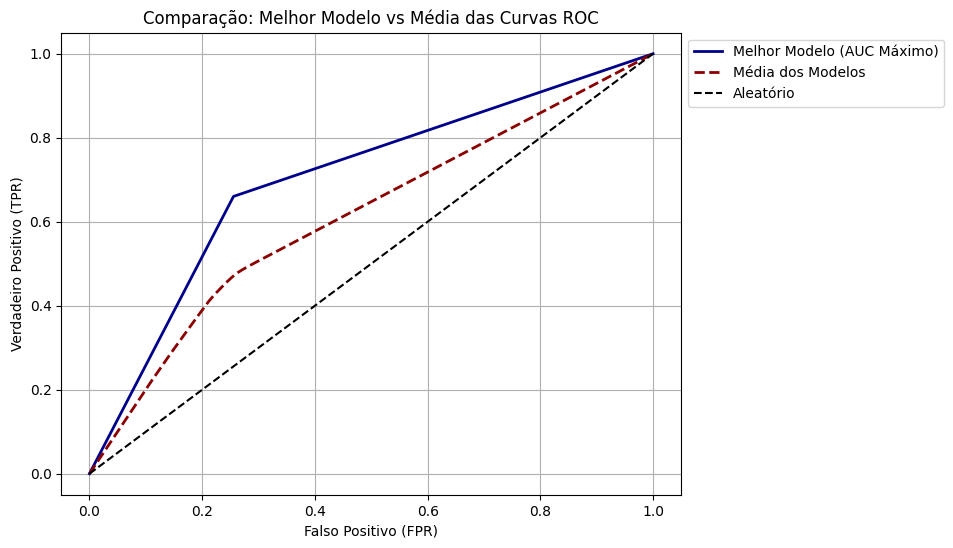

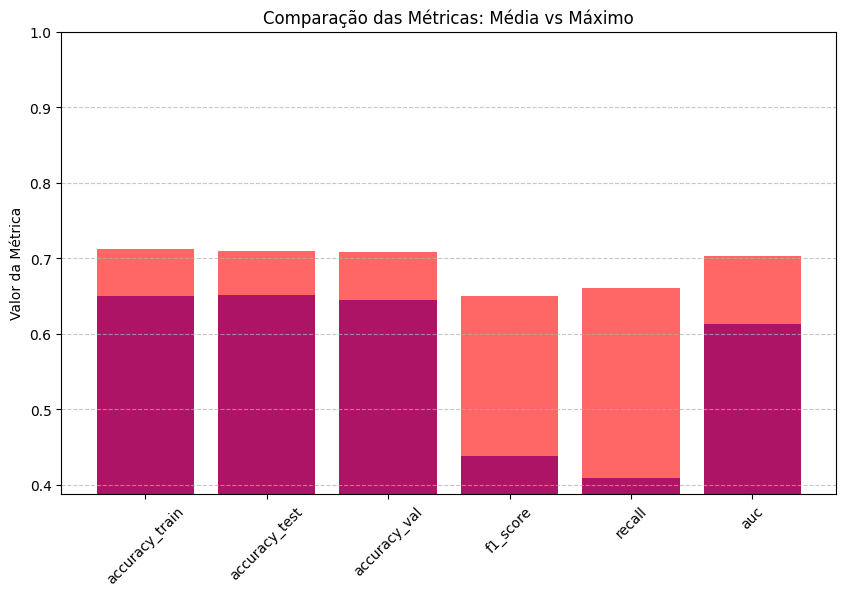

In [23]:
from IPython.display import display, Markdown

plots.show_best_roc(df)
plots.show_bar_metrics2(df)
plots.show_confusion_matrix(model, X_test, Y_test)
plots.show_metrics_comparison_line_plot(df)
plots.plot_cv_performance(cv, "Desempenho do Melhor Modelo na Cross Validation")
plots.plot_cv_performance(all_cv, "Desempenho Médio dos Modelos Selecionados na Cross Validation")
display(Markdown(util.generate_markdown_report(model, result.values())))

In [32]:
cv.to_csv('/home/guilhermemaciel/Área de Trabalho/SI5-ELEC2/data/results/lvq_cv.csv', index=False)

In [25]:
df.to_csv('/home/guilhermemaciel/Área de Trabalho/SI5-ELEC2/data/results/lvq.csv', index=False)